
# I Used the Twitter API to Build Mimetic Value's Social Network Graph

A graph is a technique used by mathematicians and others to visualize relationships among members of a group. The word "social" here has to do with social media, something that gets "follow each other" not just for the root, but also its 1st and 2nd degree connections.

Here I scrape twitter for screen names, the **Followed** (upstream), and **Followers** (downstream) links shown in the users homepage.


# Load the various utility libraries

This is written as if you were running the notebook within a clone of my notebooks repository from a Microsoft Windows operating system.

In [1]:

# Install the Twarc library
!pip install --upgrade Twarc --quiet

In [96]:

# Install the xmltodict library
!pip install xmltodict --upgrade --quiet

In [2]:

# Grab some storage utility functions using load magic
%run ../../load_magic/storage.py
%who

DATA_FOLDER: ../data/
SAVES_FOLDER: ../saves/
DATA_FOLDER	 ENCODING_TYPE	 SAVES_FOLDER	 attempt_to_pickle	 load_csv	 load_dataframes	 load_object	 os	 pd	 
pickle	 save_dataframes	 store_objects	 xmltodict	 



# Prepare the directional graph for adding nodes and edges to

In [78]:

from twarc import Twarc
import numpy as np
import networkx as nx
import re

mimetic_twarc = Twarc(config=r'C:\Users\dev\.twarc')
screen_name = 'MimeticValue'
user_id = '971039581406748672'
mimetic_following_set = set(mimetic_twarc.friend_ids(user_id))
print('{} is following {} others.'.format(screen_name, len(mimetic_following_set)))
mimetic_followers_set = set(mimetic_twarc.follower_ids(user_id))
print('{} has {} followers.'.format(screen_name, len(mimetic_followers_set)))

mimetic_digraph = nx.DiGraph()
node_list = [user_id]
mimetic_digraph.add_node(user_id)
pos_dict = {}

MimeticValue is following 294 others.
MimeticValue has 5341 followers.


This code in the cell below is just a hack to force networkx to distribute the nodes in a random way across 100 slots so as not to write the labels on top of one another.

In [79]:

from random import shuffle

y_supply = list(range(100))
shuffle(y_supply)

def y():
    
    return (y_supply.pop())

In [80]:

def build_graph(mimetic_digraph, user_id, mimetic_following_set, mimetic_followers_set, level):
    
    for influences_id in mimetic_following_set:
        if influences_id not in node_list:
            mimetic_digraph.add_node(influences_id)
        mimetic_digraph.add_edge(influences_id, user_id)
        if influences_id not in node_list:
            if level < 2:
                level += 1
                influences_following_set = set(mimetic_twarc.friend_ids(influences_id))
                influences_followers_set = set(mimetic_twarc.follower_ids(influences_id))
                mimetic_digraph = build_graph(mimetic_digraph, influences_id, influences_following_set,
                                              influences_followers_set, level)
            node_list.append(influences_id)
    
    for influenced_id in mimetic_followers_set:
        if influenced_id not in node_list:
            mimetic_digraph.add_node(influenced_id)
        mimetic_digraph.add_edge(user_id, influenced_id)
        if influenced_id not in node_list:
            if level < 2:
                level += 1
                influenced_following_set = set(mimetic_twarc.friend_ids(influenced_id))
                influenced_followers_set = set(mimetic_twarc.follower_ids(influenced_id))
                mimetic_digraph = build_graph(mimetic_digraph, influenced_id, influenced_following_set,
                                              influenced_followers_set, level)
            node_list.append(influenced_id)
    
    return mimetic_digraph


# Add the nodes and edges

And store the graph as a pickle so I don't have to keep on recreating it.

In [81]:

mimetic_digraph = build_graph(mimetic_digraph, user_id, mimetic_following_set, mimetic_followers_set, level=0)
store_objects(mimetic_digraph=mimetic_digraph)

Pickling to ../saves/pickle/mimetic_digraph.pickle


In [82]:

# trim the nodes that don't form triangles
mimetic_digraph = load_object('mimetic_digraph')
degree_view = list(mimetic_digraph.degree())
for node, degree in degree_view:
    if degree < 2:
        mimetic_digraph.remove_node(node)
nx.write_gexf(mimetic_digraph, SAVES_FOLDER+'/gexf/mimetic_digraph.gexf')

In [83]:

import collections

degree_sequence = sorted([d for n, d in mimetic_digraph.degree()], reverse=True)
degreeCount = collections.Counter(degree_sequence)
degree_tuple, count_tuple = zip(*degreeCount.items())
print(degree_tuple, count_tuple)

(982, 883, 745, 711, 6, 5, 4, 3, 2) (1, 1, 1, 1, 2, 3, 21, 140, 1392)


In [86]:

# Let's look at Mimetic's profile
for lookup_dict in mimetic_twarc.user_lookup([screen_name], id_type='screen_name'):
    for key, value in lookup_dict.items():
        print('{}: {}'.format(key, value))
    print()
    print()

id: 971039581406748672
id_str: 971039581406748672
name: Mimetic Value
screen_name: MimeticValue
location: exponential growth curve
description: Being-towards-co(s)mic-horror. Interdisciplinary theory of value: nonergodicity in myths, sacrifice, desire, fitness, zen, networks, anomalies & innovation
url: https://t.co/n22FNSBE50
entities: {'url': {'urls': [{'url': 'https://t.co/n22FNSBE50', 'expanded_url': 'http://mimeticarbitrage.com/Value%20Mythology.pdf', 'display_url': 'mimeticarbitrage.com/Value%20Mythol…', 'indices': [0, 23]}]}, 'description': {'urls': []}}
protected: False
followers_count: 5340
friends_count: 294
listed_count: 88
created_at: Tue Mar 06 15:07:32 +0000 2018
favourites_count: 26999
utc_offset: None
time_zone: None
geo_enabled: False
verified: False
statuses_count: 9184
lang: en
status: {'created_at': 'Sun Jul 29 01:16:29 +0000 2018', 'id': 1023376683817160709, 'id_str': '1023376683817160709', 'full_text': '@MatthausAnsatz @cognazor The problem with IDW is that they p


# Use the Gephi layout

It turns out it is hard to create a visualization that lets you see each node an edge. So I imported the graph into Gephi.

In [138]:

# Export the graph into Gephi
nx.write_gexf(mimetic_digraph, SAVES_FOLDER+'/gexf/pre_gephi_mimetic_digraph.gexf')


Next, I ran the Expansion, Force Atlas, Fruchterman Feingold, Yifan Hu, and Rotate layouts until I got a nice looking graph. Then I exported the Graph file as a GEXF.

In [3]:

import xmltodict

with open(SAVES_FOLDER+'gexf/post_gephi_mimetic_digraph.gexf', 'r') as fid:
    mimetic_xml = fid.read()
mimetic_tree = xmltodict.parse(mimetic_xml)

In [4]:

import numpy as np

# Get the position dictionary from the GEXF saved from Gephi
node_dict_list = mimetic_tree['gexf']['graph']['nodes']['node']
pos_dict = {node_dict['@id']: np.array([float(node_dict['viz:position']['@x']),
                                       float(node_dict['viz:position']['@y'])]) for node_dict in node_dict_list}

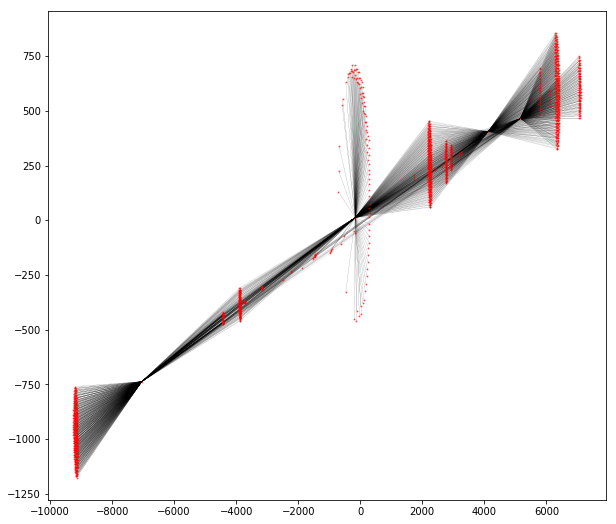

In [7]:

import matplotlib.pyplot as plt
import networkx as nx
%matplotlib inline

# Draw the graph using the default spring layout
mimetic_digraph = nx.read_gexf(SAVES_FOLDER+'/gexf/pre_gephi_mimetic_digraph.gexf')
plt.figure(figsize=(10,9))
node_collection = nx.draw_networkx_nodes(G=mimetic_digraph, pos=pos_dict, alpha=0.5, node_size=1)
edge_collection = nx.draw_networkx_edges(G=mimetic_digraph, pos=pos_dict, alpha=0.5, width=0.1, arrows=False)
#labels_collection = nx.draw_networkx_labels(G=mimetic_digraph, pos=pos_dict, font_size=14)

In [8]:

store_objects(mimetic_pos_dict=pos_dict)

Pickling to ../saves/pickle/mimetic_pos_dict.pickle



# Categorize the users by a cluster analysis of the node positions

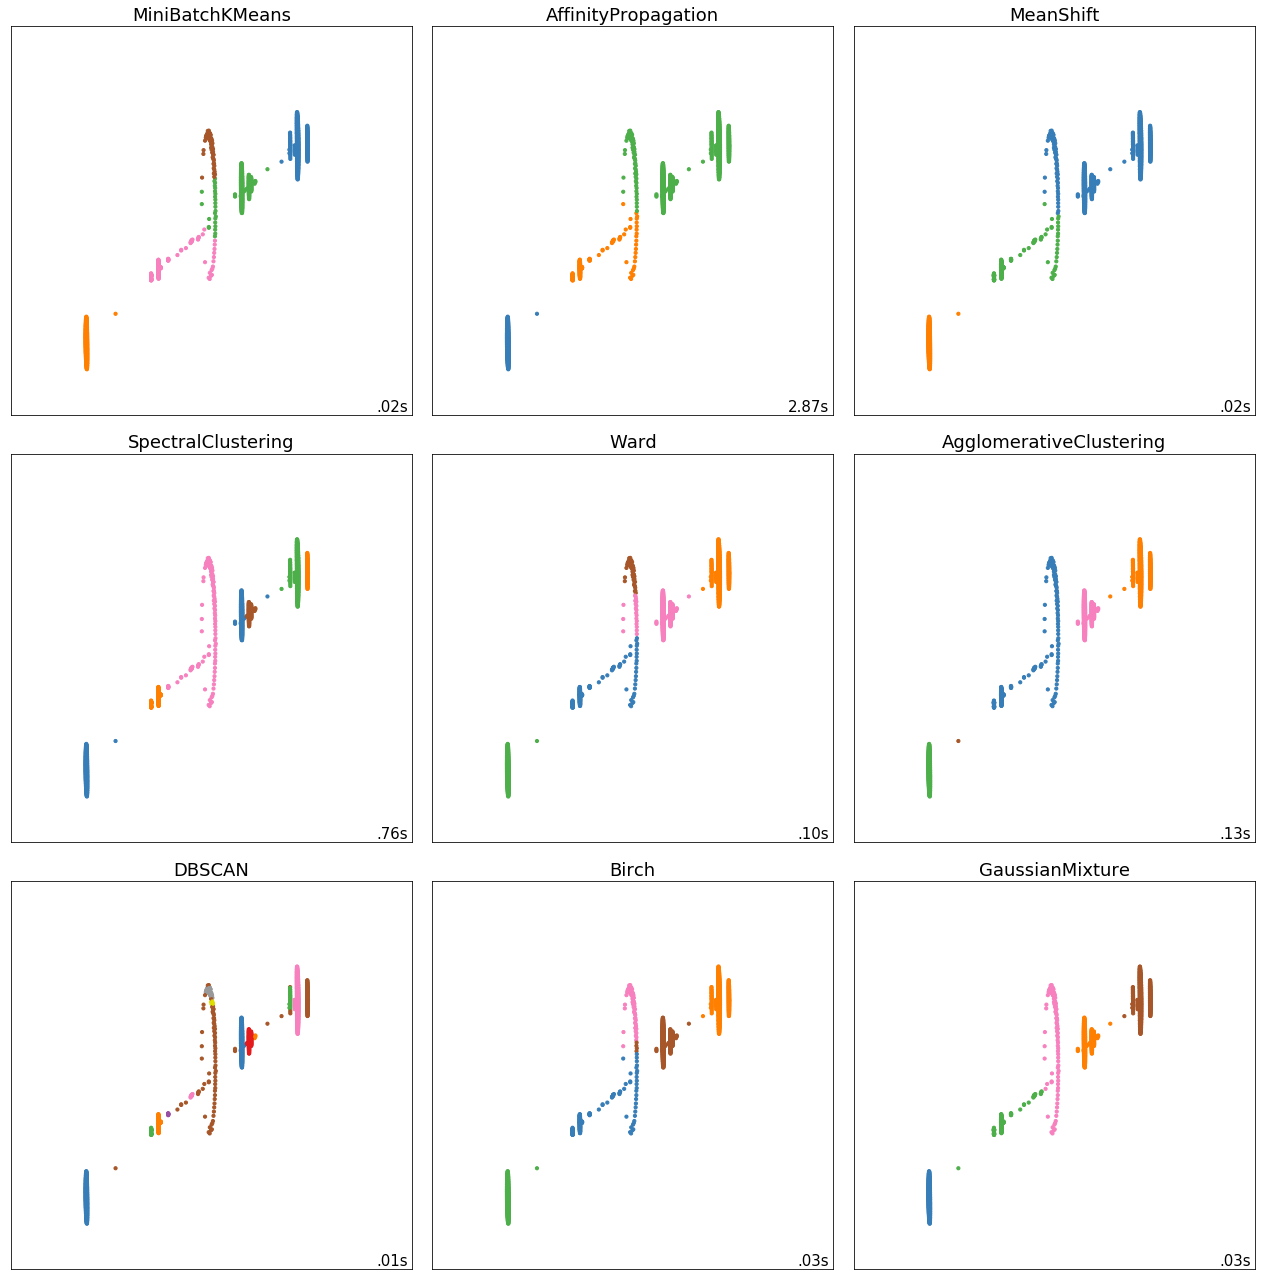

In [9]:

from sklearn.preprocessing import StandardScaler
from sklearn import cluster, mixture
from sklearn.neighbors import kneighbors_graph
import time
import warnings
from itertools import cycle, islice

plt.figure(figsize=(18, 18))
plt.subplots_adjust(left=.02, right=.98, bottom=.001, top=.96, wspace=.05,
                    hspace=.1)
plot_num = 1
params = {'quantile': .3, 'eps': .03, 'damping': .9, 'preference': -200,
          'n_neighbors': 10, 'n_clusters': 5, 'threshold': 0.4}

X = np.array([np.array([float(node_dict['viz:position']['@x']),
                        float(node_dict['viz:position']['@y'])]) for node_dict in node_dict_list])

# Normalize dataset for easier parameter selection
X = StandardScaler().fit_transform(X)

# Estimate bandwidth for mean shift
bandwidth = cluster.estimate_bandwidth(X, quantile=params['quantile'])

# Connectivity matrix for structured Ward
connectivity = kneighbors_graph(X, n_neighbors=params['n_neighbors'],
                                include_self=False)
# Make connectivity symmetric
connectivity = 0.5 * (connectivity + connectivity.T)

# ============
# Create cluster objects
# ============
ms = cluster.MeanShift(bandwidth=bandwidth, bin_seeding=True)
two_means = cluster.MiniBatchKMeans(n_clusters=params['n_clusters'])
ward = cluster.AgglomerativeClustering(n_clusters=params['n_clusters'],
                                       linkage='ward', connectivity=connectivity)
spectral = cluster.SpectralClustering(n_clusters=params['n_clusters'],
                                      eigen_solver='arpack', affinity="nearest_neighbors")
dbscan = cluster.DBSCAN(eps=params['eps'])
affinity_propagation = cluster.AffinityPropagation(damping=params['damping'],
                                                   preference=params['preference'])
average_linkage = cluster.AgglomerativeClustering(linkage="average", affinity="cityblock",
                                                  n_clusters=params['n_clusters'],
                                                  connectivity=connectivity)
birch = cluster.Birch(threshold=params['threshold'], branching_factor=50,
                      n_clusters=params['n_clusters'], compute_labels=True, copy=True)
gmm = mixture.GaussianMixture(n_components=params['n_clusters'], covariance_type='full')

clustering_algorithms = (
    ('MiniBatchKMeans', two_means),
    ('AffinityPropagation', affinity_propagation),
    ('MeanShift', ms),
    ('SpectralClustering', spectral),
    ('Ward', ward),
    ('AgglomerativeClustering', average_linkage),
    ('DBSCAN', dbscan),
    ('Birch', birch),
    ('GaussianMixture', gmm)
)

for name, algorithm in clustering_algorithms:
    t0 = time.time()

    # catch warnings related to kneighbors_graph
    with warnings.catch_warnings():
        warnings.filterwarnings(
            "ignore",
            message="the number of connected components of the " +
            "connectivity matrix is [0-9]{1,2}" +
            " > 1. Completing it to avoid stopping the tree early.",
            category=UserWarning)
        warnings.filterwarnings(
            "ignore",
            message="Graph is not fully connected, spectral embedding" +
            " may not work as expected.",
            category=UserWarning)
        algorithm.fit(X)

    t1 = time.time()
    if hasattr(algorithm, 'labels_'):
        y_pred = algorithm.labels_.astype(np.int)
    else:
        y_pred = algorithm.predict(X)

    plt.subplot(3, 3, plot_num)
    plt.title(name, size=18)

    colors = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a',
                                         '#f781bf', '#a65628', '#984ea3',
                                         '#999999', '#e41a1c', '#dede00']),
                                  int(max(y_pred) + 1))))
    plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[y_pred])

    plt.xlim(-2.5, 2.5)
    plt.ylim(-2.5, 2.5)
    plt.xticks(())
    plt.yticks(())
    plt.text(.99, .01, ('%.2fs' % (t1 - t0)).lstrip('0'),
             transform=plt.gca().transAxes, size=15,
             horizontalalignment='right')
    plot_num += 1


# Label the users by an n-gram tf-idf of their tweets

In [10]:

import re
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
import string
from nltk import sent_tokenize

url_regex = re.compile(r"\b(?:(?:https?|ftp|file)://|www\.|ftp\.)[-A-Z0-9+&@#/%=~_|$?!:,.]*[A-Z0-9+&@#/%=~_|$]", re.IGNORECASE)
ellipse_regex = re.compile(r"\s+\xa0…")
username_regex = re.compile(r"@\w{1,15}\b")

def clean_tweets_list(tweets_list):
    user_sentences_list = []
    for tweets_str in tweets_list:
        tweets_str = url_regex.sub('', tweets_str)
        tweets_str = ellipse_regex.sub('', tweets_str)
        tweets_str = username_regex.sub('', tweets_str)
        sentences_list = sent_tokenize(tweets_str)
        for sentence in sentences_list:
            user_sentences_list.append(sentence)
    
    return user_sentences_list

In [11]:

from nltk.tokenize import word_tokenize

table_dict = str.maketrans('', '', string.punctuation)
porter = PorterStemmer()
stop_words_list = ['rt', 'btc', 'eth', 'jpi', 'lt']
for lang_str in ['english', 'spanish', 'arabic']:
    stop_words_list.extend(stopwords.words(lang_str))
stop_words_set = set(stop_words_list)

def clean_sentences_list(sentences_list):
    stemmed_list_list = []
    for sentence_str in sentences_list:
        tokens_list = word_tokenize(sentence_str)

        # Remove punctuation from each word
        stripped_list = [w.translate(table_dict) for w in tokens_list]

        # Remove all tokens that are not alphabetic and lower-case them
        words_list = [word.lower() for word in stripped_list if word.isalpha()]

        # Filter out stop words
        words_list = [w for w in words_list if not w in stop_words_set]

        # Stemming of words
        stemmed_list = [porter.stem(word) for word in words_list]

        stemmed_list_list.append(stemmed_list)
    
    return stemmed_list_list

In [12]:

import networkx as nx
from twarc import Twarc

mimetic_digraph = nx.read_gexf(SAVES_FOLDER+'/gexf/pre_gephi_mimetic_digraph.gexf')
mimetic_twarc = Twarc(config=r'C:\Users\dev\.twarc')
user_name_dict = {}
user_stemmed_list_list_dict = {}
for node in mimetic_digraph.nodes():
    for lookup_dict in mimetic_twarc.user_lookup([node]):
        user_name = lookup_dict['name']
        user_name_dict[node] = user_name
        tweets_list = []
        for tweet_dict in mimetic_twarc.search(node):
            tweets_list.append(tweet_dict['full_text'])
        user_sentences_list = clean_tweets_list(tweets_list)
        user_stemmed_list_list = clean_sentences_list(user_sentences_list)
        user_stemmed_list_list_dict[node] = user_stemmed_list_list
store_objects(user_name_dict=user_name_dict, user_stemmed_list_list_dict=user_stemmed_list_list_dict)

Pickling to ../saves/pickle/user_name_dict.pickle
Pickling to ../saves/pickle/user_stemmed_list_list_dict.pickle


In [12]:

from nltk import ngrams

user_stemmed_list_list_dict = load_object('user_stemmed_list_list_dict')
user_ngrams_statistics = {}
for n in range(2, 0, -1):
    for user_id, user_stemmed_list_list in user_stemmed_list_list_dict.items():
        for stemmed_list in user_stemmed_list_list:
            ngrams_generator = ngrams(stemmed_list, n)
            for ngram in ngrams_generator:
                if ngram in user_ngrams_statistics.keys():
                    ngram_occurrences = user_ngrams_statistics[ngram]
                    user_ngrams_statistics.update({ngram:ngram_occurrences+1})
                else:
                    user_ngrams_statistics.update({ngram:1})
user_ngrams_statistics_sorted = sorted(user_ngrams_statistics.items(), reverse=True, key=lambda x: x[1])
ngrams_statistics_blank = [(x[0], 0) for x in user_ngrams_statistics_sorted]

C:\Users\dev\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: generator 'ngrams' raised StopIteration
  # Remove the CWD from sys.path while we load stuff.


In [13]:

# "برنامج" apparently means "a program", so I don't think that's a stop word
user_ngrams_statistics_sorted[0:3]

[(('jpi',), 65), (('برنامج',), 57), (('peronismo', 'volvió'), 39)]

In [14]:

# Get the statistics for a particular user
def get_id_ngrams_statistics(stemmed_list_list, n):
    id_ngrams_statistics = {x[0]: x[1] for x in ngrams_statistics_blank}
    for stemmed_list in stemmed_list_list:
        ngrams_generator = ngrams(stemmed_list, n)
        for ngram in ngrams_generator:
            if ngram in id_ngrams_statistics.keys():
                ngram_occurrences = id_ngrams_statistics[ngram]
                id_ngrams_statistics.update({ngram:ngram_occurrences+1})
    
    return id_ngrams_statistics